## Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
import os 
import zipfile

In [23]:
# Read file csv as a dataframe
filename = 'sorted_training_dataset_with_labels.csv'
raw_df = pd.read_csv(filename)

raw_df.head()

any = raw_df[(raw_df['any'] == 1) & 
                            (raw_df['epidural'] == 0) & 
                            (raw_df['intraparenchymal'] == 0) & 
                            (raw_df['intraventricular'] == 0) & 
                            (raw_df['subarachnoid'] == 0) & 
                            (raw_df['subdural'] == 0)]

print('Number of patients with any hemorrhage:', len(any))

Number of patients with any hemorrhage: 0


### Data Exploration
- The label `any` doesn't stand alone in the dataset. It is accompanied by other hemorrhage types.

## Patient Information - Study Instance

In [4]:
# Group by 'patient_id' and count the number of occurrences
patient_counts = raw_df.groupby('patient_id').size().reset_index(name='count')

# Display the number of patients
print('Number of patients:', len(patient_counts))

Number of patients: 18938


In [5]:
study_counts = raw_df.groupby('patient_id')['study_instance_uid'].nunique().reset_index(name='unique_study_count')

# Filter patients with more than one unique study_instance_uid
multiple_studies = study_counts[study_counts['unique_study_count'] > 1]

# Print the patient_id and the number of study_instance_uid's
print(multiple_studies)

        patient_id  unique_study_count
4      ID_000e5623                   2
12     ID_00257f20                   2
20     ID_00526c11                   2
44     ID_00a3b735                   4
61     ID_00d96858                   2
...            ...                 ...
18916  ID_ffadefb3                   6
18921  ID_ffc709c0                   8
18922  ID_ffc99fd6                   3
18925  ID_ffd4ab30                   2
18927  ID_ffd8dff8                   2

[1758 rows x 2 columns]


In [6]:
series_counts = (
    raw_df.groupby(['patient_id', 'study_instance_uid'])['series_instance_uid']
    .nunique()
    .reset_index(name='unique_series_count')
)

# Filter patients with more than one unique series_instance_uid
multiple_series = series_counts[series_counts['unique_series_count'] > 1]

# Print the result
print(multiple_series)

Empty DataFrame
Columns: [patient_id, study_instance_uid, unique_series_count]
Index: []


### Conclusion
- A single `patient_id` may be associated with multiple `study_instance_uid` entries.
- However, each `study_instance_uid` corresponds to only one unique `series_instance_uid`.

This indicates that while patients can have multiple studies, each study consists of a single series.

## Patient Information - Hemorrhage 

In [7]:
# Group by patient_id and study_instance_uid, and check if all hemorrhage types are 0
def classify_case(group):
    # Check if all hemorrhage types are 0
    if (group[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']] == 0).all().all():
        return 'Normal'
    else:
        return 'Abnormal'

# Group by patient_id and study_instance_uid
grouped = raw_df.groupby(['patient_id'])

# Apply the classification function to each group
classification = grouped.apply(classify_case)

# Convert the classification Series to a DataFrame
classification_df = classification.reset_index(name='case_type')

# Count the occurrences of normal and abnormal cases
case_counts = classification_df['case_type'].value_counts().reset_index()
case_counts.columns = ['case', 'count']

# Display the table of normal and abnormal counts
print("Table of Normal and Abnormal Counts:")
print(case_counts)

Table of Normal and Abnormal Counts:
       case  count
0    Normal  11286
1  Abnormal   7652


/tmp/ipykernel_6727/590375313.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  classification = grouped.apply(classify_case)


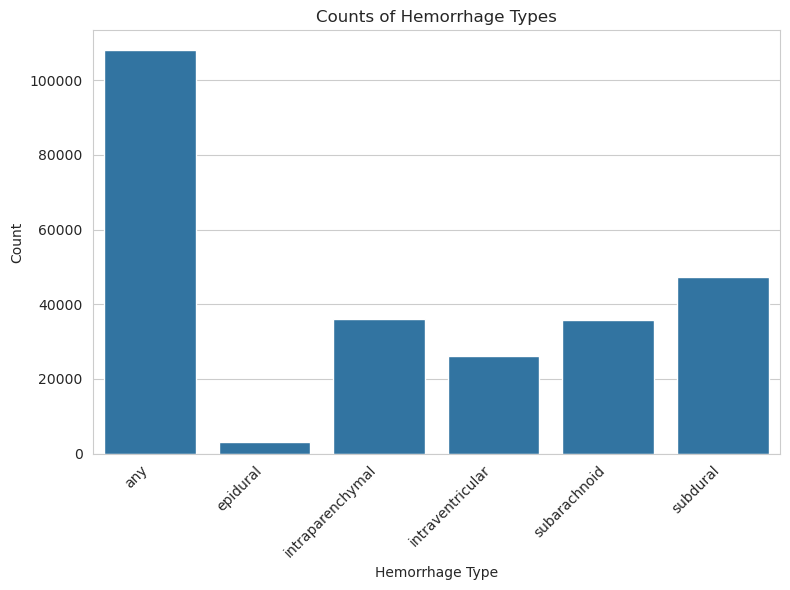

In [8]:
# Create a new DataFrame to count the number of occurrences for each hemorrhage type
hemorrhage_counts = raw_df[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum()

# Convert the Series to a DataFrame for plotting
hemorrhage_counts = hemorrhage_counts.reset_index()
hemorrhage_counts.columns = ['hemorrhage_type', 'count']

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='hemorrhage_type', y='count', data=hemorrhage_counts)
plt.title('Counts of Hemorrhage Types')
plt.xlabel('Hemorrhage Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Generate Scan Level Label

In [9]:
# Create a new DataFrame to count the number of occurrences for each hemorrhage type
scan_level_df = raw_df.groupby(['patient_id', 'study_instance_uid'])[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].max()

# Reset the index
scan_level_df = scan_level_df.reset_index()

# Get the columns to merge
# columns_to_merge = raw_df.columns.difference(scan_level_df.columns)

# Merge the columns
# scan_level_df = scan_level_df.merge(raw_df[columns_to_merge].drop_duplicates(subset=['patient_id', 'study_instance_uid']), on=['patient_id', 'study_instance_uid'], how='left')

scan_level_df.head()

,patient_id,study_instance_uid,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_0002cd41,ID_66929e09d4,0,0,0,0,0,0
1,ID_00054f3f,ID_8a449ae31b,0,0,0,0,0,0
2,ID_0006d192,ID_25690b4725,0,0,0,0,0,0
3,ID_00086119,ID_fdde2979b0,0,0,0,0,0,0
4,ID_000e5623,ID_9a4be35b9a,0,0,0,0,0,0


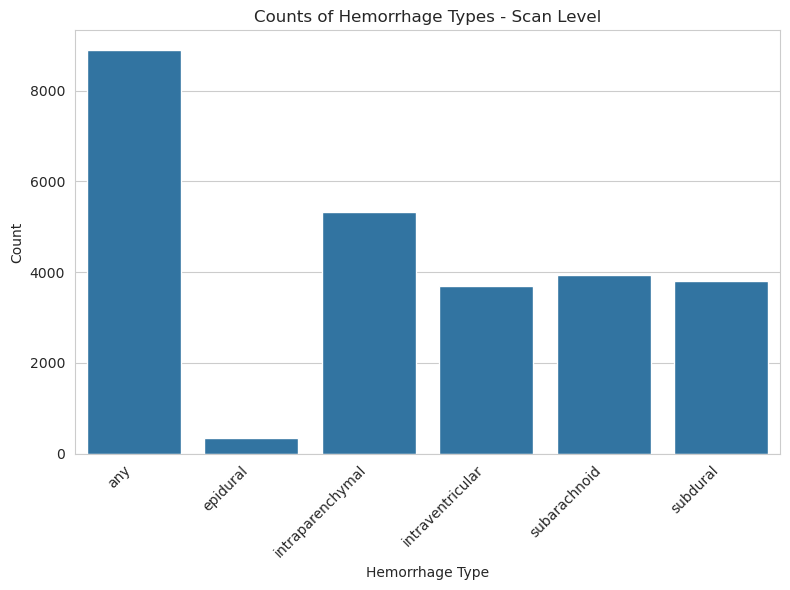

In [10]:
# Create a new DataFrame to count the number of occurrences for each hemorrhage type
hemorrhage_counts = scan_level_df[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum()

# Convert the Series to a DataFrame for plotting
hemorrhage_counts = hemorrhage_counts.reset_index()
hemorrhage_counts.columns = ['hemorrhage_type', 'count']

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='hemorrhage_type', y='count', data=hemorrhage_counts)
plt.title('Counts of Hemorrhage Types - Scan Level')
plt.xlabel('Hemorrhage Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Save to a new csv file
scan_level_df.to_csv('scan_level_dataset.csv', index=False)

## Copy first 1000 cases for training

In [12]:
# Read scan_level_dataset.csv as a DataFrame 
scan_level_df = pd.read_csv('scan_level_dataset.csv')

In [13]:
# Define paths
zip_file_path = './rsna-intracranial-hemorrhage-detection.zip'
destination_dir = './rsna-mil-training'
os.makedirs(destination_dir, exist_ok=True)

In [14]:
# Extract the first 1000 rows
scan_subset = scan_level_df.head(1000)

# Get patient_id and study_instance_uid
patient_ids = scan_subset['patient_id']
study_uids = scan_subset['study_instance_uid']

In [25]:
# Save scan_subset to a new csv file
scan_subset.to_csv('training_1000_scan_subset.csv', index=False)

In [ ]:
# Initialize a list to hold filenames
filenames_to_copy = []

# Iterate through the extracted patient IDs and study UIDs
for patient_id, study_uid in zip(patient_ids, study_uids):
    matching_files = raw_df[(raw_df['patient_id'] == patient_id) & 
                            (raw_df['study_instance_uid'] == study_uid)]
    # Append the filenames to the list
    filenames_to_copy.extend(matching_files['filename'].tolist())

In [27]:
# Define paths
zip_file_path = 'rsna-intracranial-hemorrhage-detection.zip'
destination_dir = './rsna-mil-training'
train_images_dir = 'rsna-intracranial-hemorrhage-detection/stage_2_train'

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for index, row in scan_subset.iterrows():
        patient_id = row['patient_id']
        study_instance_uid = row['study_instance_uid']
        
        # Remove 'ID_' prefix from patient_id and study_instance_uid
        patient_id_clean = patient_id.replace('ID_', '')
        study_instance_uid_clean = study_instance_uid.replace('ID_', '')

        # Create the subdirectory name without the 'ID_' prefix
        subdirectory_name = f"{patient_id_clean}_{study_instance_uid_clean}"
        subdirectory_path = os.path.join(destination_dir, subdirectory_name)
        os.makedirs(subdirectory_path, exist_ok=True)
        
        # Filter raw_df for matching patient_id and study_instance_uid
        matching_files = raw_df[(raw_df['patient_id'] == patient_id) & 
                                 (raw_df['study_instance_uid'] == study_instance_uid)]
        
        # Copy each matching file from the ZIP to the subdirectory
        for _, file_row in matching_files.iterrows():
            filename = file_row['filename']
            # Construct the full path inside the ZIP
            zip_file_path_in_zip = os.path.join(train_images_dir, filename)
            
            # Check if the file exists in the ZIP
            if zip_file_path_in_zip in zip_ref.namelist():
                # Extract the file from the zip and save it to the destination directory
                with zip_ref.open(zip_file_path_in_zip) as source_file:
                    destination_file_path = os.path.join(subdirectory_path, filename)
                    with open(destination_file_path, 'wb') as dest_file:
                        dest_file.write(source_file.read())
            else:
                print(f"File {zip_file_path_in_zip} not found in the ZIP archive.")

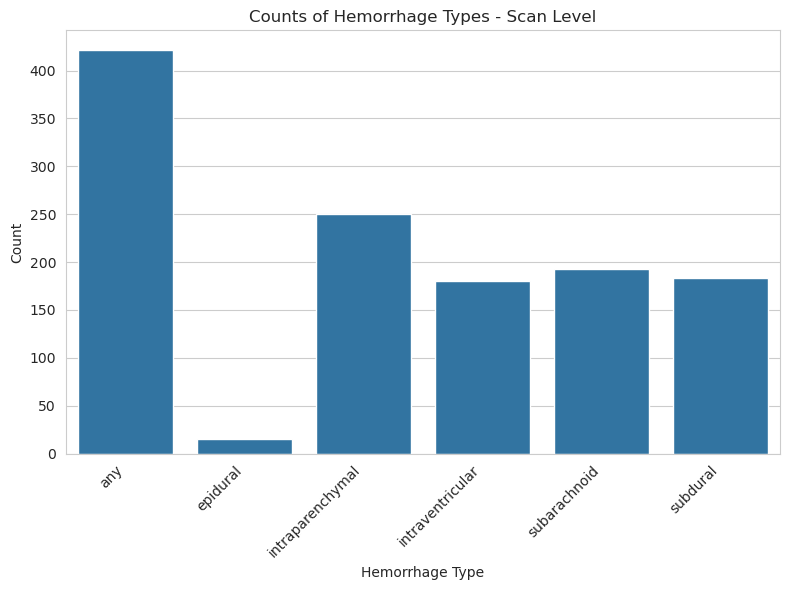

In [16]:
# Create a new DataFrame to count the number of occurrences for each hemorrhage type
hemorrhage_counts = scan_subset[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum()

# Convert the Series to a DataFrame for plotting
hemorrhage_counts = hemorrhage_counts.reset_index()
hemorrhage_counts.columns = ['hemorrhage_type', 'count']

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='hemorrhage_type', y='count', data=hemorrhage_counts)
plt.title('Counts of Hemorrhage Types - Scan Level')
plt.xlabel('Hemorrhage Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
# Count the number of patient who have no hemorrhage types, means that all labels are 0
no_hemorrhage = scan_subset[(scan_subset['any'] == 0) & 
                            (scan_subset['epidural'] == 0) & 
                            (scan_subset['intraparenchymal'] == 0) & 
                            (scan_subset['intraventricular'] == 0) & 
                            (scan_subset['subarachnoid'] == 0) & 
                            (scan_subset['subdural'] == 0)]

any = scan_subset[(scan_subset['any'] == 1) & 
                            (scan_subset['epidural'] == 0) & 
                            (scan_subset['intraparenchymal'] == 0) & 
                            (scan_subset['intraventricular'] == 0) & 
                            (scan_subset['subarachnoid'] == 0) & 
                            (scan_subset['subdural'] == 0)]

# Display the number of patients with no hemorrhage
print('Number of patients with no hemorrhage:', len(no_hemorrhage))
print('Number of patients with any hemorrhage:', len(any))

Number of patients with no hemorrhage: 579
Number of patients with any hemorrhage: 75
